## Perguntas:

**O que significa energia fotovoltaica?**

A energia fotovoltaica trata-se de uma alternativa para a geração de energia limpa. A mesma é caracterizada pela da geração de energia a partir da luz solar, mais precisamente através da conversão de fótons para elétrons.

**O que são séries temporais?**

Séries temporais podem ser entendidas como valores ordenados em relação ao tempo. 

**Que algoritimo de machine learning você pensou em utilizar?**

Alguns fatores que podem ser analizados são:
1. K-means ( para realizar possíveis agrupamentos entre zonas de irradiação)
2. Regressões ( para analizar se variáveis como latitude e longitude estão relacionados a irradiação)
3. Forecasting ( para a projeção e previsão de níveis de irradiação para datas futuras)

**Como a SolarView utiliza dados para gerar valor para seus clientes?**

A utilização de dados pode gerar valor não só para seus clientes mas também para a própria empresa. Através de dashboards com dados gerados a partir dos equipamentos instalados é possível dar ao cliente poder e entedimento sobre a sua geração de energia. Além disso, tais dados permitem que equipamentos mais inteligentes que sejam capazes de entender o abiente gerando o máximo de aproveitamento energético. Além de auxiliar a SolarView na tomada de decisão.
<hr>

## Modelagem do banco de dados
Ao analisar a API<sup>1</sup> da Nasa é possível tem-se que os dados estão estruturados da seguinte forma:

`LAT,LON,YEAR,MO,DY,ALLSKY_SFC_SW_DWN`

Onde:

- LAT = Latitude
- LON = Longitude
- YEAR = Ano
- MO = Mês
- DY = Dia
- ALLSKY_SFC_SW_DWN = irradiação

Dessa forma, podemos concentrar o ano, mês e dia em uma única coluna do banco de dados. Ficando da seguinte forma:

`LAT,LON,DATE,ALLSKY_SFC_SW_DWN`

## Instalando dependências

In [31]:
# Requirements
# !docker exec -ti --user root jupyter sh -c "apt update -y && apt upgrade -y"
!docker exec -ti --user root jupyter sh -c "apt install -y  libssl1.0.0 libssl-dev"
# !pip install -r requirements.txt

# !docker exec -ti --user root jupyter sh -c "conda install --yes --file ${PWD}/requirements.txt"

%config IPCompleter.greedy=True
%matplotlib inline

Got permission denied while trying to connect to the Docker daemon socket at unix:///var/run/docker.sock: Get http://%2Fvar%2Frun%2Fdocker.sock/v1.39/containers/jupyter/json: dial unix /var/run/docker.sock: connect: permission denied


In [169]:
# Instalando dependências
import datetime
import pymysql
import requests
import folium
from folium.plugins import HeatMap
import overpy
import time
import json
import countries
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import utils

## Criando banco de dados
para criar o banco de dados e a tabela onde os dados que virão da API iremos utilizar o script abaixo

In [ ]:
# Criando banco de dados
utils.criar_banco()

## Criando dataset com pontos de interesse
A seguir serão gerados diversos pontos, porém alguns desses pontos não estão localizados no Brasil. Dessa forma precisamos filtrar quais pontos pertencem e quais não.

Para realizar o filtro iremos utilizar a classe `CountryChecker`<sup>2</sup> como pode ser visto a seguir:

In [2]:
# Carrehando Shapes dos países
cc = countries.CountryChecker('resources/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp')

# Carregando geojson do Brasil
with open('resources/brazil.geojson') as json_data:
    d = json.load(json_data)
    coordinates = d['features'][0]['geometry']['coordinates']

# Reduzingo poligonos para um único array
brazil_boundary = []
for l in coordinates:
    l = np.array(l).flatten()
    brazil_boundary = np.concatenate((brazil_boundary, l), axis=None)

# Transformando array para pares coordernados
brazil_boundary = np.reshape(brazil_boundary,(-1,2))

# Gerando matriz transposta
brazil_boundaryT = np.array(brazil_boundary).T

# Gerando latitudes
lats = np.arange(brazil_boundaryT[0].min(),brazil_boundaryT[0].max(),0.5)

# Gerando longitudes
lngs = np.arange(brazil_boundaryT[1].min(),brazil_boundaryT[1].max(),0.5)

# Percorrendo latitudes e longitudes e filtrando pontos que pertencem ao Brasil
point_matrix = []
for lat in tqdm(lats):
    for i in range(len(lngs)):
        try:
            country_iso = cc.getCountry(countries.Point(lngs[i], lat)).iso
            if country_iso == "BR":
                point_matrix.append([lat, lngs[i]])
        except:
            pass


100%|██████████| 91/91 [05:53<00:00,  7.90s/it]


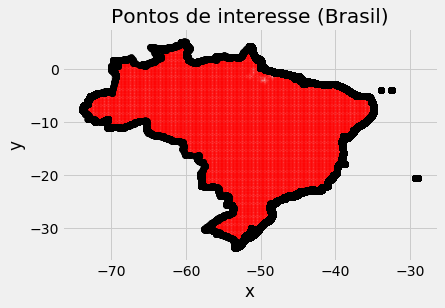

In [173]:
# Visualizando pontos de interesse
point_matrixT = np.array(point_matrix).T
plt.scatter(point_matrixT[0],point_matrixT[1], c= [1,0,0], alpha=0.5)
plt.scatter(brazil_boundaryT[0], brazil_boundaryT[1], c=[0,0,0], alpha=0.5)
plt.title('Pontos de interesse (Brasil)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Recuperando dados da API da NASA
Iremos utilizar a API da NASA para recuperar os dados de irradiação para cada ponto gerado na etapa anterior

In [8]:
# Salvando irradiação para todos os pontos de interesse
for coord in tqdm(point_matrix[1690:]):
    response = utils.get_irradiacao(coord[0], coord[1])
    utils.salvar_irradiacao(response)


100%|██████████| 1136/1136 [2:14:52<00:00,  8.02s/it]

## Visualização

### Visualizando irradiação diária

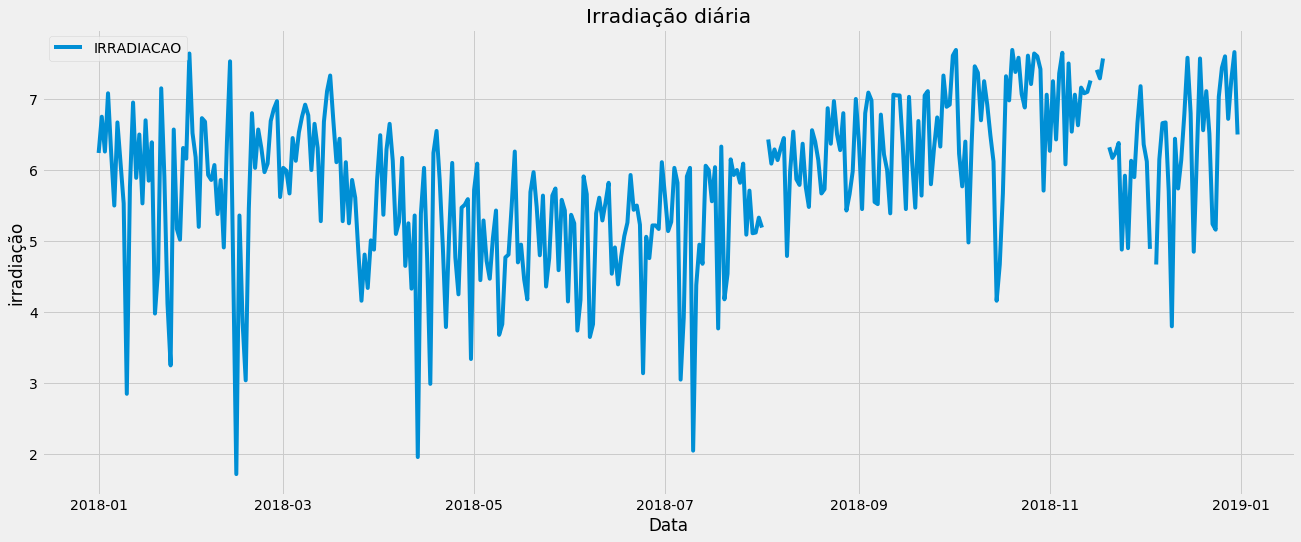

In [172]:
#recupetando dados

#Definindo localização
coordinate = ['-36.4897','-6.74707']

# Recuperando conexão com o banco
conexao = utils.pegar_conexao()

# Definindo consulta
query = "SELECT asText(pt), alt, DATE, ALLSKY_SFC_SW_DWN from `nasa_solarview`.`point` join `nasa_solarview`.`irradiacao` on `irradiacao`.`point_id` = `nasa_solarview`.`point`.id  WHERE st_contains(pt, point({}, {}));".format(coordinate[0],coordinate[1])

# Recuperando dados
try:
     with conexao.cursor() as cursor:
            cursor.execute(query)
            result = cursor.fetchall()
finally:
    conexao.close()  

# Criando array com resultados
dataset = [ x for x in result]

# Cria DataFrame
df = pd.DataFrame(dataset, columns = ['POINT','ALT','DATE','IRRADIACAO'])

#Cria data frame de série temporal
ts_df = pd.DataFrame(df[['DATE','IRRADIACAO']])

# Trocando -999 para NaN (Necessário pois a API devolve -999 para dados nulos)
ts_df['IRRADIACAO'] = ts_df['IRRADIACAO'].replace(-999, np.NaN)

# Gerando gráfico para insolação diária

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

ax = ts_df.set_index('DATE').plot(figsize=(20, 8))
ax.set_ylabel('irradiação')
ax.set_xlabel('Data')
plt.title('Irradiação diária')

plt.show()


### Visualizando irradiação mensal

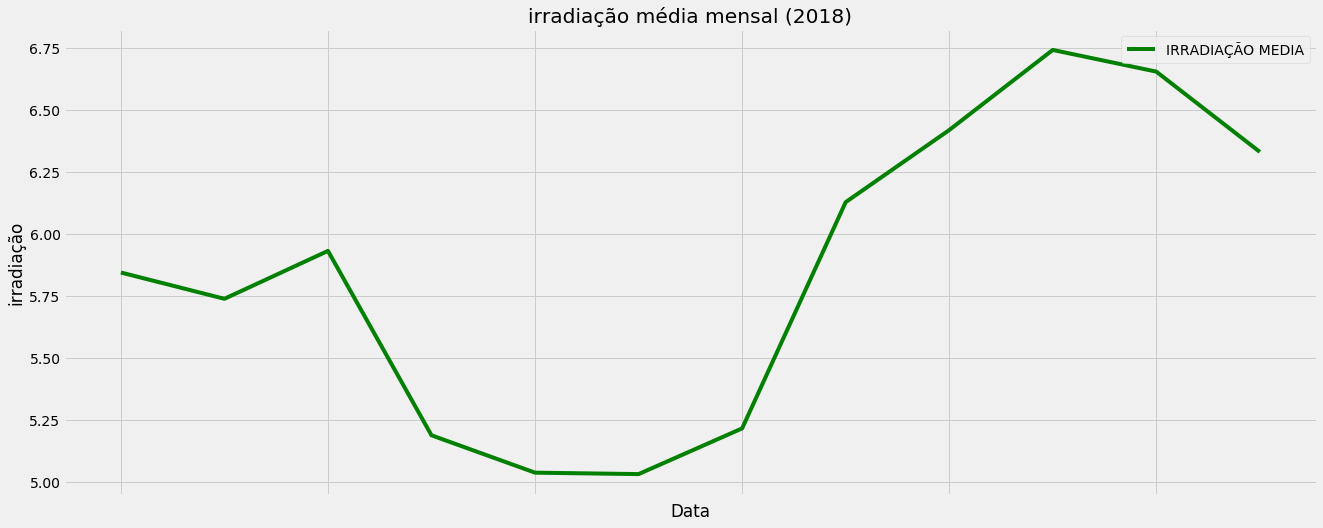

In [34]:
# Gerando gráfico para insolação média mensal
meses = np.unique(['{0:%Y}-{0:%m}'.format(x) for x in ts_df['DATE'].values])
ts_df['MES'] = ['{0:%Y}-{0:%m}'.format(x) for x in ts_df['DATE'].values]
values = ts_df.groupby(['MES']).mean()['IRRADIACAO'].values

ts_df_mes = pd.DataFrame({'MES': list(meses), 'IRRADIAÇÃO MEDIA': list(values)})
ax = ts_df_mes.set_index('MES').plot(figsize=(20, 8), style = ['g'])

ts_df_mes['MES'] = pd.to_datetime(ts_df_mes['MES'], format='%Y-%m')
ts_df_mes.set_index('MES',inplace=True)
# ts_df_mes.index = ['jan','fev','mar','abr','mai','jun','jul','ago','set','out','nov','dev']
ax.set_ylabel('irradiação')
ax.set_xlabel('Data')
plt.title('irradiação média mensal (2018)')
plt.show()

### Visualizando mapa de calor

In [147]:
# Recuperando conexão com o banco
conexao = utils.pegar_conexao()

# Definindo data
date = '2018-12-31'

# Definindo consulta
query = "SELECT asText(pt), alt, date, ALLSKY_SFC_SW_DWN from `nasa_solarview`.`point` join `nasa_solarview`.`irradiacao` on `irradiacao`.`point_id` = `nasa_solarview`.`point`.id  WHERE `irradiacao`.`date` = '{}';".format(date)

# Recuperando dados
try:
     with conexao.cursor() as cursor:
            cursor.execute(query)
            result = cursor.fetchall()
finally:
    conexao.close()  

# Criando array com resultados
dataset = [ x for x in result]

for i in range(len(dataset)):
    coords = dataset[i][0].replace('POINT(','').replace(')','').split(' ')
    dataset[i] = list(dataset[i]) + coords
    

# Cria DataFrame
df = pd.DataFrame(dataset, columns = ['POINT','ALT','DATE','IRRADIACAO','LAT','LON'])
df = df.drop(columns = ['POINT','DATE'])

df['LAT'] = pd.to_numeric(df['LAT'])
df['LON'] = pd.to_numeric(df['LON'])
df['IRRADIACAO'] = pd.to_numeric(df['IRRADIACAO'])
df['IRRADIACAO'] = df['IRRADIACAO'].replace(-999, np.NaN)

df = df.dropna()

In [171]:
latitudes = df['LAT'].values
longitudes = df['LON'].values
irradiacoes = df['IRRADIACAO'].values

# Normalizando os dados de irradiação
irr_max = irradiacoes.max()
irr_min = irradiacoes.min()

irradiacoes = np.array([(x - irr_min) / (irr_max - irr_min) for x in irradiacoes])

# Preparando dados para o heatmap
data = list(zip(longitudes, latitudes, irradiacoes))

# Criando mapa
m = folium.Map([lngs.mean(), lats.mean()], tiles='stamentoner', zoom_start=5)

#Criando heatmap
HeatMap(data).add_to(m)

# Exibindo mapa
m

## Referências

[1] https://power.larc.nasa.gov/docs/v1/index.html

[2] https://github.com/che0/countries